## Sources

-Bayesian Optimization: A step by step approach: https://towardsdatascience.com/bayesian-optimization-a-step-by-step-approach-a1cb678dd2ec

-Practical Bayesian Optimization of Machine Learning Algorithms: https://arxiv.org/abs/1206.2944

## Libraries

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Bayesian Optimizer

In [24]:
# Bayesian Optimizer
class bayesian_opt():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei',"time"])
        self.distances_ = []
        
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
        
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun[0] < min_ei:
                    min_ei = response.fun[0]
                    x_optimal = response.x
            
            return x_optimal, min_ei
    
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        x_opt = np.array([])
        y_opt = np.array([])
        iter_time = np.array([])
        
        for i in range(self.n_iter):
            start_time = time.time() # Record the start time
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if i == 0:
                 prev_x = x_next
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei[0]

            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
                
            end_time = time.time() # Record the end time
            iteration_time = end_time - start_time # Calculate the time for this iteration
            print(i, x_next,y_next)
            
            #Store results
            x_opt = np.append(x_opt, optimal_x)
            y_opt = np.append(y_opt, y_max)
            iter_time = np.append(iter_time, iteration_time)
        
        # Consolidate results into a dataframe
        data = np.hstack((x_opt.reshape(self.n_iter, 2), y_opt.reshape(-1, 1), iter_time.reshape(-1, 1))) # stack the arrays horizontally to form a 2D array
        results = pd.DataFrame(data) # create a dataframe from the 2D array

        return optimal_x, y_max, results

## Black Box Functions

In [25]:
def branin_hoo(x):
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    total = np.array([])
    for x_i in x:
        term1 = a * (x_i[1] - b * x_i[0] ** 2 + c * x_i[0] - r) ** 2
        term2 = s * (1 - t) * np.cos(x_i[0])
        total = np.append(total, term1 + term2 + s)
    return total

def branin_hoo_max(x):
    #Inverse of the branin_hoo function. Will be used for our approach since it maximizes a function
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    total = np.array([])
    for x_i in x:
        term1 = a * (x_i[1] - b * x_i[0] ** 2 + c * x_i[0] - r) ** 2
        term2 = s * (1 - t) * np.cos(x_i[0])
        total = np.append(total, -(term1 + term2 + s))
    return total

def logistic_reg_mnist(x):
    total = np.array([])
    for x_i in x:
        c_val = abs(x_i[0])
        penalty_val = x_i[1] 
        if penalty_val > 0.5:
            penalty_cat = "l1"
        else:
            penalty_cat = "l2"
        clf2 = LogisticRegression(fit_intercept=True,
                            multi_class='auto',
                            penalty=penalty_cat, #lasso regression
                            solver='saga',
                            max_iter=1000,
                            C=c_val,
                            verbose=2, # output progress
                            n_jobs=5, # parallelize over 5 processes
                            tol=0.01
                             )
        clf2.fit(X_train, y_train)
        score = clf2.score(X_test, y_test)
        total = np.append(total,score)
    return total

## Branin-hoo Function - Our Approach

In [4]:
sample_x = np.array([[-2,5],[5,10]])
sample_y = branin_hoo_max(sample_x)
bopt = bayesian_opt(target_func=branin_hoo_max, x_init=sample_x, y_init=sample_y, n_iter=100, scale=10, batch_size=30)

#Optimize
start_time = time.time() # Record the start time
x_max_bh, y_max_bh, df_bh = bopt.optimize()
end_time = time.time() # Record the end time
bh_time = end_time - start_time # Calculate the time for this iteration

0 [9.13502366 0.39088211] [-4.22269537]
1 [10.8135643   7.49082328] [-21.18735028]
2 [-2.86281589 25.32654693] [-188.77313227]
3 [-4.14954771 13.02547099] [-8.12769033]
4 [ 0.82347847 -0.41658904] [-43.49962496]
5 [-14.41608101  59.9430159 ] [-24.59177158]
6 [4.98951656 4.02034322] [-20.16387019]
7 [ 7.17769607 -5.41298737] [-60.1636985]
8 [27.36657172  4.30645455] [-3016.82087711]
9 [14.6266324   1.45886746] [-84.68926258]
10 [ 15.37491425 -18.66892937] [-945.66776594]
11 [12.2122174  13.05358522] [-71.18632907]
12 [-9.81109277  7.89396157] [-685.23457878]
13 [-0.52780291 19.0421956 ] [-166.31143623]
14 [-8.56883687  0.3258521 ] [-832.98696718]
15 [13.05780916 -4.59843622] [-158.72406883]
16 [14.98710074 18.96054273] [-63.57522534]
17 [-1.21269269 32.52658104] [-609.04466962]
18 [-0.36733885  9.95097323] [-30.17667483]
19 [ 5.35049915 -0.98982415] [-20.43958906]
20 [17.32859229  8.95972967] [-78.58202174]
21 [1.91492675 6.50829001] [-16.26089513]
22 [-29.50789803  41.98223848] [-15250

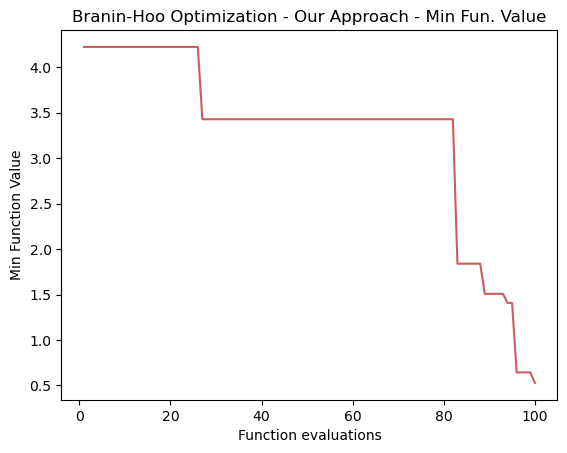

In [52]:
# Get min values of the function
bh_mins = -df_bh.iloc[:,-2]
index_bh = df_bh.index +1

# create the plot
plt.plot(index_bh, bh_mins, color='indianred') 

# add axis labels and a title
plt.xlabel('Function evaluations')
plt.ylabel('Min Function Value')
plt.title('Branin-Hoo Optimization - Our Approach - Min Fun. Value')

# display the plot
plt.show()

## Branin-Hoo - Hyperopt

In [53]:
# define the search space
space = {
    'x1': hp.uniform('x1', -5, 10),
    'x2': hp.uniform('x2', 0, 15)
}

# define the objective function to be minimized
def objective(params):
    x = [[params['x1'], params['x2']]]
    loss = branin_hoo(x)
    return {'loss': loss[0], 'status': STATUS_OK}

# perform the optimization
start_time = time.time() # Record the start time
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
end_time = time.time() # Record the end time
bh_time_hyp = end_time - start_time # Calculate the time for this iteration
print('Best parameters:', best)

100%|██████████| 100/100 [00:00<00:00, 259.46trial/s, best loss: 0.7139050335560473]
Best parameters: {'x1': 9.267899944893223, 'x2': 2.7909363390513096}


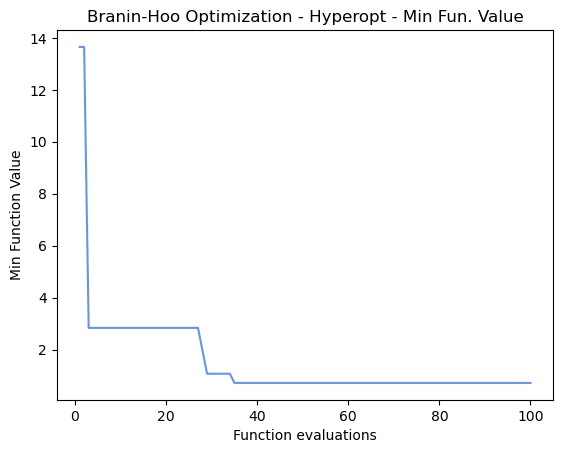

In [54]:
# plot the minimum value of the function for each iteration
losses = [trial['result']['loss'] for trial in trials.trials]
iters = [i+1 for i in range(len(losses))]
bh_mins_hyp = [min(losses[:i+1]) for i in range(len(losses))]
plt.plot(iters, bh_mins_hyp, color = "cornflowerblue")
plt.xlabel('Function evaluations')
plt.ylabel('Min Function Value')
plt.title('Branin-Hoo Optimization - Hyperopt - Min Fun. Value')
plt.show()

## Branin-Hoo - Our Approach vs. Hyperopt

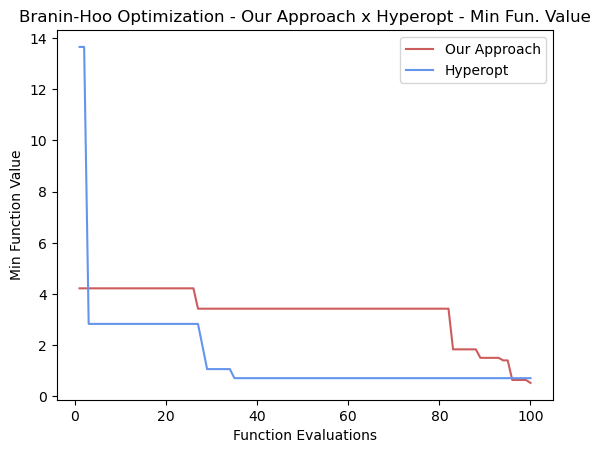

In [55]:
# plot the data with different colors
plt.plot(index_bh, bh_mins, 'indianred', label='Our Approach')  # red line
plt.plot(index_bh, bh_mins_hyp, 'cornflowerblue', label='Hyperopt')  # blue line

# add a legend
plt.legend()

# add axis labels and a title
plt.xlabel('Function Evaluations')
plt.ylabel('Min Function Value')
plt.title('Branin-Hoo Optimization - Our Approach x Hyperopt - Min Fun. Value')

# display the plot
plt.show()

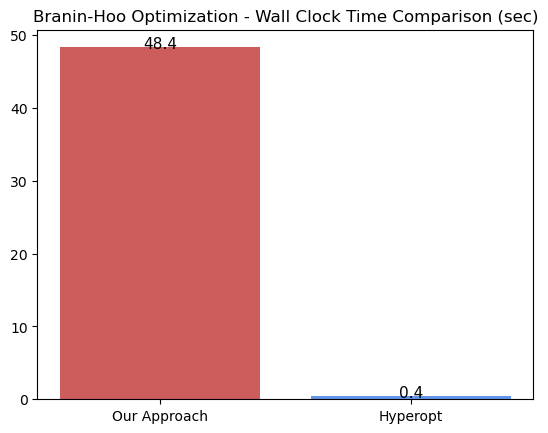

In [56]:
# Compare Wall Clock time of our approach vs. hyperopt library
# Define the data
our_approach_time = bh_time
hyperopt_time = bh_time_hyp

# Create a bar graph
fig, ax = plt.subplots()
bars = ax.bar(['Our Approach', 'Hyperopt'], [our_approach_time, hyperopt_time], color=['indianred', 'cornflowerblue'])

# Add the values above the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height+0.5, '%.1f' % float(height), ha='center', va='center', color='black', fontsize=11)


# Set the title
ax.set_title("Branin-Hoo Optimization - Wall Clock Time Comparison (sec)")

# Show the graph
plt.show()

## Logistic Regression - MNIST - Data Acquisition

In [26]:
# Import MNIST dataset
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

In [27]:
# Break dataset between train and test
X_train, X_test, y_train, y_test = train_test_split(mnist.data, 
                                                    mnist.target.astype('int'), #targets str to int convert
                                                   test_size=1/7.0,
                                                   random_state=0)
# Normalize the data
X_train /= 255.0
X_test /= 255.0

## Logistic Regression - MNIST - Our Approach

In [28]:
# Starting sample for the Gaussian Process
sample_x = np.array([[40,50],[.2,.3]])
sample_y = logistic_reg_mnist(sample_x)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 50 epochs took 181 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 24 epochs took 44 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   43.4s finished


In [29]:
# Optimize
start_time = time.time() # Record the start time

bopt = bayesian_opt(target_func=logistic_reg_mnist, x_init=sample_x, y_init=sample_y, n_iter=10, scale=10, batch_size=30)
x_max_mnist, y_max_mnist, df_mnist = bopt.optimize()

end_time = time.time() # Record the end time
logistic_time = end_time - start_time # Calculate the time for this iteration

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 32 epochs took 58 seconds
0 [-0.49179998 -0.3292761 ] [0.9204]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   58.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 42 epochs took 152 seconds
1 [-0.68257653  0.57518921] [0.921]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 28 epochs took 51 seconds
2 [-0.32510364  0.24486157] [0.9206]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   51.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 43 epochs took 79 seconds
3 [-1.68056137 -0.0315045 ] [0.9197]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 42 epochs took 79 seconds
4 [-1.43977467 -1.10312008] [0.9199]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 39 epochs took 144 seconds
5 [0.40655012 1.40689429] [0.9205]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 45 epochs took 162 seconds
6 [1.29542092 0.91504933] [0.9209]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 42 epochs took 156 seconds
7 [0.65778439 0.88621979] [0.9206]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 41 epochs took 73 seconds
8 [ 1.57384643 -0.23396161] [0.9199]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 38 epochs took 70 seconds
9 [ 0.82953915 -1.04592213] [0.92]


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.2min finished


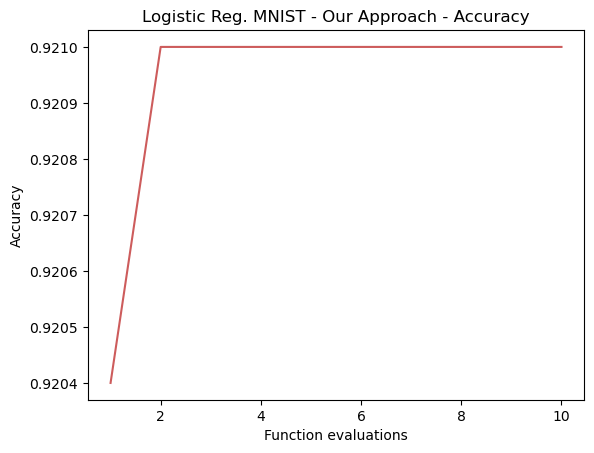

In [30]:
# Define Series
logistic_mins = df_mnist.iloc[:,-2]
index = df_mnist.index +1

# create the plot
plt.plot(index, logistic_mins, color='indianred') 

# add axis labels and a title
plt.xlabel('Function evaluations')
plt.ylabel('Accuracy')
plt.title('Logistic Reg. MNIST - Our Approach - Accuracy')

# display the plot
plt.show()

## Logistic Regression - MNIST - Hyperopt

In [31]:
# Define Hyperparameter Space
space = {
    'C': hp.loguniform('C', -5, 5),
    'penalty': hp.choice('penalty', ['l1', 'l2'])
}

# Define the objective function to be minimized
def objective(params):
    # Create the Logistic Regression classifier with given hyperparameters
    clf = LogisticRegression(C=params['C'], penalty=params['penalty'], solver='liblinear')
    # Train the classifier on the training set
    clf.fit(X_train, y_train)
    # Predict the labels of the testing set
    y_pred = clf.predict(X_test)
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    # Return the negative accuracy (to be minimized)
    return -accuracy

#Optimize and record wall clock time
start_time = time.time() # Record the start time

# Create a Trials object to keep track of the iterations
trials = Trials()

# Run the hyperparameter search using the Tree-structured Parzen Estimator (TPE) algorithm
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)


end_time = time.time() # Record the end time
logistic_time_hyp = end_time - start_time # Calculate the time for this iteration

100%|██████████| 10/10 [06:58<00:00, 41.83s/trial, best loss: -0.9114]


In [37]:
# Track the best accuracy over the iterations for plotting
best = float('inf')  # initialize best to positive infinity
losses = []
for trial in trials.trials:
    loss = trial['result']['loss']
    if loss < best:
        best = loss
    losses.append(best)
iters = [i for i in range(len(losses))]
 
def Convert(lst):
    return [ -i for i in lst ]
 
# Driver code
logistic_mins_hyp = Convert(losses)

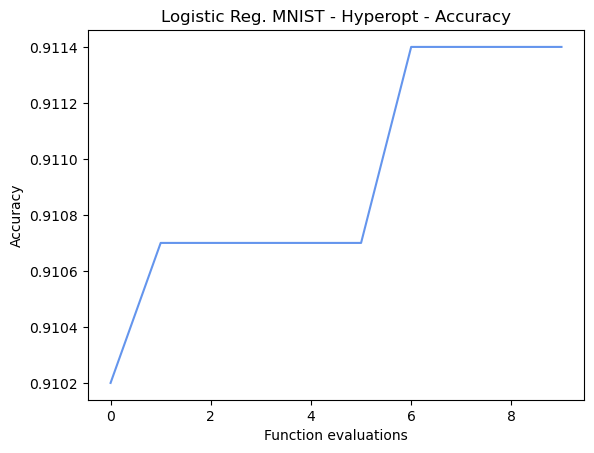

In [38]:
# plot the loss vs. iteration
plt.plot(iters, logistic_mins_hyp, color = "cornflowerblue")
plt.xlabel('Function evaluations')
plt.ylabel('Accuracy')
plt.title('Logistic Reg. MNIST - Hyperopt - Accuracy')
plt.show()

## Logistic Regression - MNIST - Our Approach vs. Hyperopt

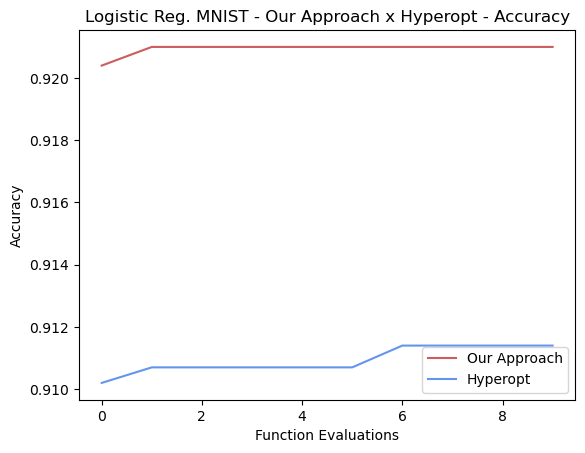

In [39]:
# plot the data with different colors
plt.plot(iters, logistic_mins, 'indianred', label='Our Approach')  # red line
plt.plot(iters, logistic_mins_hyp, 'cornflowerblue', label='Hyperopt')  # blue line

# add a legend
plt.legend()

# add axis labels and a title
plt.xlabel('Function Evaluations')
plt.ylabel('Accuracy')
plt.title('Logistic Reg. MNIST - Our Approach x Hyperopt - Accuracy')

# display the plot
plt.show()

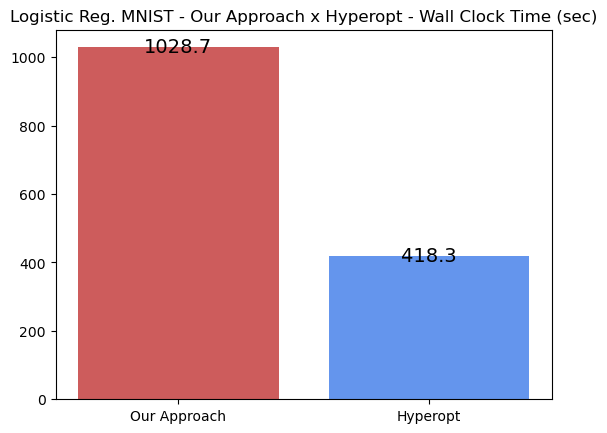

In [40]:
# Compare Wall Clock time of our approach vs. hyperopt library
# Define the data
our_approach_time = logistic_time
hyperopt_time = logistic_time_hyp

# Create a bar graph
fig, ax = plt.subplots()
bars = ax.bar(['Our Approach', 'Hyperopt'], [our_approach_time, hyperopt_time], color=['indianred', 'cornflowerblue'])

# Add the values above the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height+0.5, '%.1f' % float(height), ha='center', va='center', color='black', fontsize=14)


# Set the title
ax.set_title("Logistic Reg. MNIST - Our Approach x Hyperopt - Wall Clock Time (sec)")

# Show the graph
plt.show()